In [1]:
import sympy as sp
import minterpy as mp
import numpy as np
from minterpy.pointcloud_utils import *

from mpl_toolkits import mplot3d
%matplotlib inline

import torch
import torchvision
from torchvision import transforms, datasets

import random
import numpy as np
import matplotlib.pyplot as plt

import os
from operator import itemgetter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import ot

from sklearn.neighbors import NearestNeighbors

import ripser
import persim
from persim import plot_diagrams

from operator import itemgetter


#do pip installs as follows to use vedo for plotting point clouds
#pip install vedo
#pip install ipyvtklink

import numpy as np
from vedo import *

In [2]:
def getFashionMNIST(batch_size = 120):
    fashionmnist_data = torchvision.datasets.FashionMNIST(download=True, root = 'data/fashionmnist', transform = 
                                                                                 transforms.Compose([transforms.Resize(32),
                                                                                 transforms.ToTensor(), 
                                                                                 transforms.Lambda(lambda x: x.repeat(1, 1, 1))
                                                                                 ]))
    train_loader = torch.utils.data.DataLoader(fashionmnist_data,
                                              batch_size=batch_size,
                                              shuffle=False,
                                              num_workers=16)
    return train_loader, train_loader



def getDataset(dataset = "MNIST", batch_size = 120):
    if(dataset == "MNIST"):
        train_loader, test_loader = getMNIST(batch_size)
        noChannels,dx, dy = train_loader.dataset.__getitem__(1)[0].shape
    elif(dataset == "FashionMNIST"):
        train_loader, test_loader = getFashionMNIST(batch_size)
        noChannels, dx, dy = train_loader.dataset.__getitem__(1)[0].shape
    elif(dataset == "Cifar10"):
        train_loader, test_loader = getCifar10(batch_size)
        noChannels, dx, dy = train_loader.dataset.__getitem__(1)[0].shape
        """
    elif(dataset == "cityscapes"):
        train_loader, test_loader = getcityscapes(batch_size)
        noChannels, dx, dy = train_loader.dataset.__getitem__(1)[0].shape
        """
    else:
        return None, None, None, None, None    
        
    return train_loader, test_loader, noChannels, dx, dy

In [3]:
train_loader, test_loader, noChannels, dx, dy = getDataset("FashionMNIST")  # FashionMNIST , MNIST

/home/chethan/.local/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
for inum, (batch_x, label) in enumerate(train_loader):
    break
    

In [5]:
def _compute_distance_matrix(x, p=2):
    x_flat = x.view(x.size(0), -1)

    distances = torch.norm(x_flat[:, None] - x_flat, dim=2, p=p)

    return distances

In [6]:
def get_persistence_diagram(point_cloud, maximum_dim):

    point_cloud = torch.tensor(point_cloud)

    dist_matrix = _compute_distance_matrix(point_cloud, p=2)
    diagrams = ripser.ripser(dist_matrix.cpu().detach().numpy(), distance_matrix=True, maxdim=maximum_dim)['dgms']
    return diagrams, plot_diagrams(diagrams, show=True)


In [9]:
def indices_array(n):
    r = np.arange(n)
    out = np.empty((n,n,2),dtype=int)
    out[:,:,0] = r[:,None]
    out[:,:,1] = r
    return out

In [10]:
imageIndices = indices_array(batch_x.shape[3]).reshape(32*32,2)
imageIndices.shape

(1024, 2)

In [11]:
Mm = [[np.sum((imageIndices[i] - imageIndices[j])**2) for i in range(len(imageIndices))] for j in range(len(imageIndices)) ]

In [14]:
Mm = torch.tensor(Mm).type(torch.FloatTensor)

In [18]:
def ImageDistancesFromBarycenter(batch_x, input_barycenter, remaining_indices):
  wasserDistance = []
  distance_cum_index = np.array([])
  #Mm = [[np.sum((imageIndices[i] - imageIndices[j])**2) for i in range(len(imageIndices))] for j in range(len(imageIndices)) ]
  #for j in range(batch_x.shape[0]):
  for j in remaining_indices:
    
    #wassDistance = ot.sliced_wasserstein_distance(batch_x[j][0], input_barycenter, seed=0)  
    
    gs = ((batch_x[j][0] + 10**(-10)).reshape(1024,1)) / torch.sum((batch_x[j][0]))
    h = ((input_barycenter + 10**(-10)).reshape(1024,1)) / torch.sum((input_barycenter))
    #print(gs.shape)
    #print(h.shape)
    #print(len(Mm))
    wassDistance = ot.sinkhorn2(h, gs, Mm, 1)    

    distance_cum_index = np.concatenate((distance_cum_index, np.array([wassDistance, j])), axis = 0)

    
    
  distance_cum_index = distance_cum_index.reshape(int(distance_cum_index.shape[0]/2), 2)
  distance_cum_index = sorted(distance_cum_index, key=itemgetter(0))
  #distance_cum_index gives wasserstein distances of all images from the input barycenter
  distance_cum_index = np.array(distance_cum_index)
  #print(distance_cum_index)

  #remaining_indices = distance_cum_index[:,1][4:]

  #for convergence
  remaining_indices = distance_cum_index[:,1]

  remaining_indices = remaining_indices.astype(int)
    
  #if(len(distance_cum_index[:,1]) >= 4):
  f1 = batch_x[int(distance_cum_index[:,1][0])][0].cpu().detach().numpy()
  f2 = batch_x[int(distance_cum_index[:,1][1])][0].cpu().detach().numpy()
  f3 = batch_x[int(distance_cum_index[:,1][2])][0].cpu().detach().numpy()
  f4 = batch_x[int(distance_cum_index[:,1][3])][0].cpu().detach().numpy()  

  A = np.array([f1, f2, f3, f4])
  reg = 0.004
  weights = np.array((0.25, 0.25, 0.25, 0.25))
  next_barycenter = ot.bregman.convolutional_barycenter2d(A, reg, weights) 
  next_barycenter = torch.tensor(next_barycenter)
  next_barycenter = next_barycenter.type(torch.FloatTensor)

  return A, next_barycenter, remaining_indices


Size of batch :  120
Iteration number :  1
Input barycenter : 


/tmp/ipykernel_10190/2457649378.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(torch.tensor(bary).view(32,32))


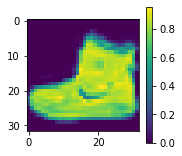

/tmp/ipykernel_10190/2457649378.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  neighbours, bary, rem_indices = ImageDistancesFromBarycenter(batch_x, torch.tensor(bary), rem_indices)


Neighbors of input barycenter :



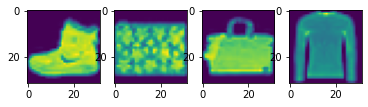

The new barycenter


/tmp/ipykernel_10190/2457649378.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  plt.imshow(torch.tensor(bary).view(32,32))


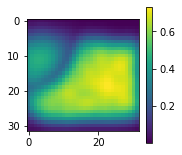

Tracking distance between new barycenter and previous barycenter :  tensor([3.5919])
Iteration number :  2
Input barycenter : 


/tmp/ipykernel_10190/2457649378.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bary = torch.tensor(bary)
/tmp/ipykernel_10190/2457649378.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gs = ((torch.tensor(old_bary) + 10**(-10)).reshape(1024,1)) / torch.sum((torch.tensor(old_bary)))
/tmp/ipykernel_10190/2457649378.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  h = ((torch.tensor(bary) + 10**(-10)).reshape(1024,1)) / torch.sum((torch.tensor(bary)))


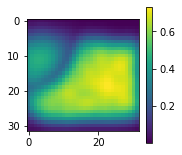

Neighbors of input barycenter :



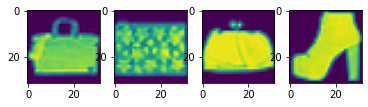

The new barycenter


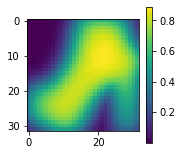

Tracking distance between new barycenter and previous barycenter :  tensor([2.9530])
Iteration number :  3
Input barycenter : 


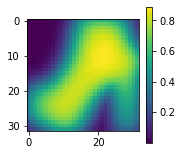

Neighbors of input barycenter :



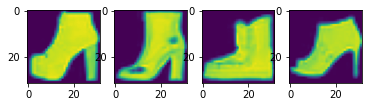

The new barycenter


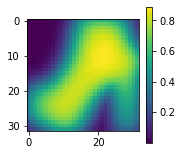

Tracking distance between new barycenter and previous barycenter :  tensor([0.9809])
Iteration number :  4
Input barycenter : 


/tmp/ipykernel_10190/2457649378.py:61: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sampled_barycenters = torch.cat((sampled_barycenters, torch.tensor(bary)), 0)


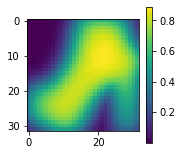

Neighbors of input barycenter :



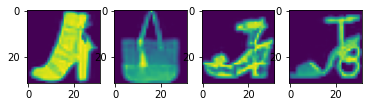

The new barycenter


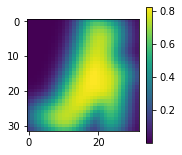

Tracking distance between new barycenter and previous barycenter :  tensor([5.0985])
Iteration number :  5
Input barycenter : 


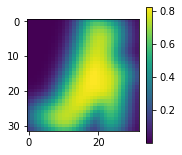

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 40
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 55
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 16
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 39
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 52
  warnings.warn('Warning: numerical errors at 

Neighbors of input barycenter :



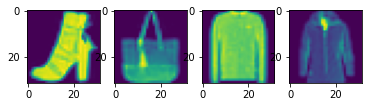

The new barycenter


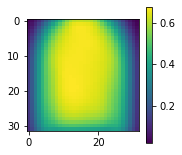

Tracking distance between new barycenter and previous barycenter :  tensor([3.1050])
Iteration number :  6
Input barycenter : 


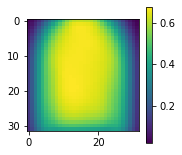

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 337
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 138
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 288
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 260
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



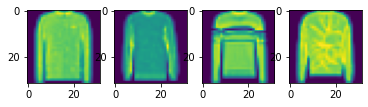

The new barycenter


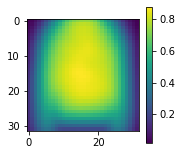

Tracking distance between new barycenter and previous barycenter :  tensor([1.5316])
Iteration number :  7
Input barycenter : 


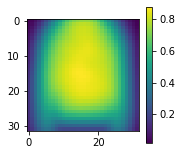

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 75
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 122
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 125
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 717
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 257
  warnings.warn('Warning: numerical errors

Neighbors of input barycenter :



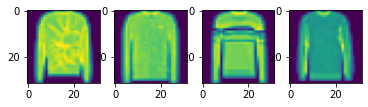

The new barycenter


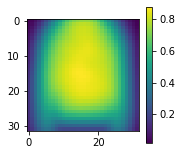

Tracking distance between new barycenter and previous barycenter :  tensor([0.9857])
Iteration number :  8
Input barycenter : 


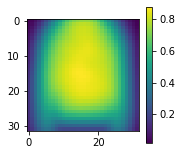

Neighbors of input barycenter :



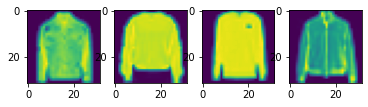

The new barycenter


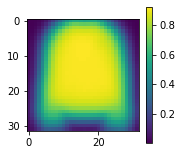

Tracking distance between new barycenter and previous barycenter :  tensor([1.5130])
Iteration number :  9
Input barycenter : 


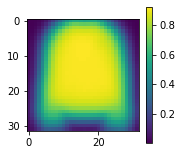

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 192
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 175
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 239
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 120
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 119
  warnings.warn('Warning: numerical error

Neighbors of input barycenter :



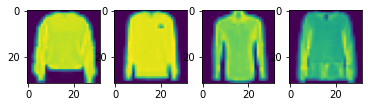

The new barycenter


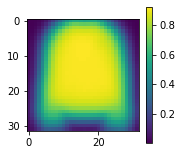

Tracking distance between new barycenter and previous barycenter :  tensor([0.9888])
Iteration number :  10
Input barycenter : 


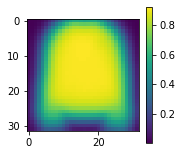

Neighbors of input barycenter :



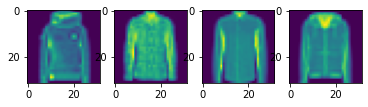

The new barycenter


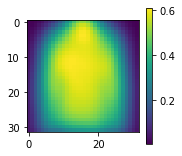

Tracking distance between new barycenter and previous barycenter :  tensor([1.9329])
Iteration number :  11
Input barycenter : 


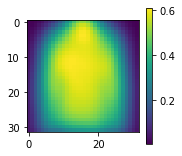

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 106
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 41
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 225
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 118
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



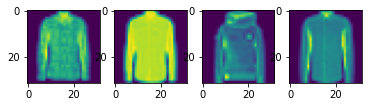

The new barycenter


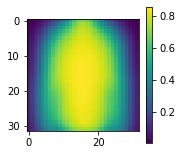

Tracking distance between new barycenter and previous barycenter :  tensor([1.3112])
Iteration number :  12
Input barycenter : 


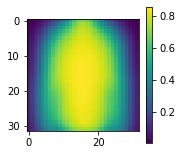

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 150
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 130
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 314
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 227
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 33
  warnings.warn('Warning: numerical errors

Neighbors of input barycenter :



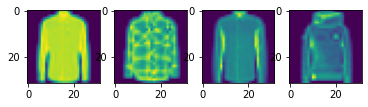

The new barycenter


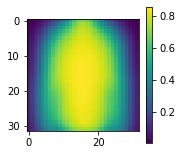

Tracking distance between new barycenter and previous barycenter :  tensor([0.9853])
Iteration number :  13
Input barycenter : 


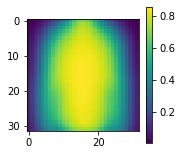

Neighbors of input barycenter :



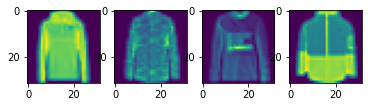

The new barycenter


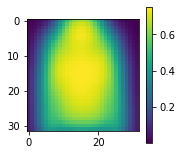

Tracking distance between new barycenter and previous barycenter :  tensor([1.1946])
Iteration number :  14
Input barycenter : 


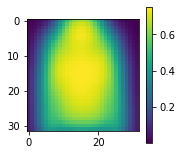

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 209
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 593
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 461
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 44
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 206
  warnings.warn('Warning: numerical errors

Neighbors of input barycenter :



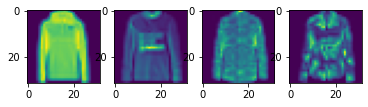

The new barycenter


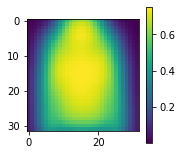

Tracking distance between new barycenter and previous barycenter :  tensor([0.9855])
Iteration number :  15
Input barycenter : 


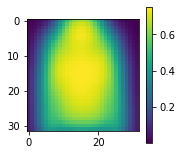

Neighbors of input barycenter :



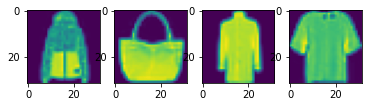

The new barycenter


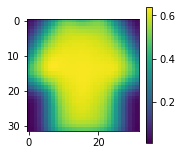

Tracking distance between new barycenter and previous barycenter :  tensor([4.7274])
Iteration number :  16
Input barycenter : 


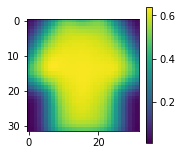

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 104
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 316
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 395
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 517
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



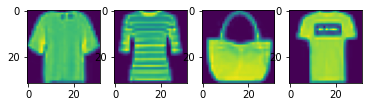

The new barycenter


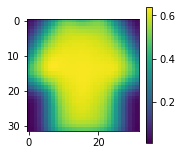

Tracking distance between new barycenter and previous barycenter :  tensor([0.9826])
Iteration number :  17
Input barycenter : 


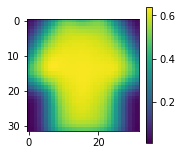

Neighbors of input barycenter :



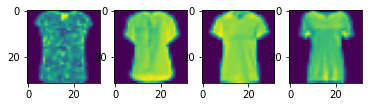

The new barycenter


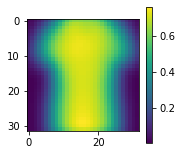

Tracking distance between new barycenter and previous barycenter :  tensor([4.0294])
Iteration number :  18
Input barycenter : 


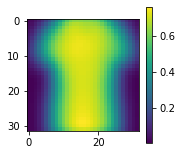

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 432
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 58
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 479
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



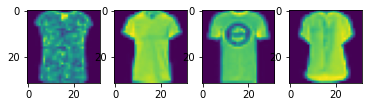

The new barycenter


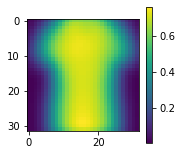

Tracking distance between new barycenter and previous barycenter :  tensor([0.9828])
Iteration number :  19
Input barycenter : 


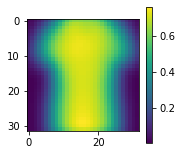

Neighbors of input barycenter :



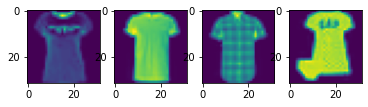

The new barycenter


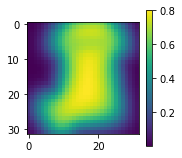

Tracking distance between new barycenter and previous barycenter :  tensor([4.1284])
Iteration number :  20
Input barycenter : 


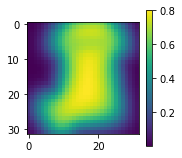

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 110
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



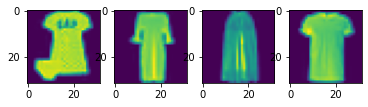

The new barycenter


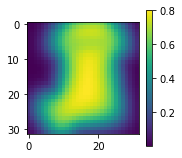

Tracking distance between new barycenter and previous barycenter :  tensor([0.9854])
Iteration number :  21
Input barycenter : 


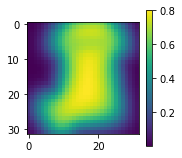

Neighbors of input barycenter :



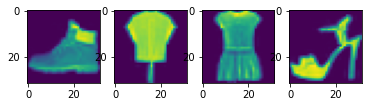

The new barycenter


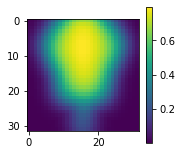

Tracking distance between new barycenter and previous barycenter :  tensor([2.0009])
Iteration number :  22
Input barycenter : 


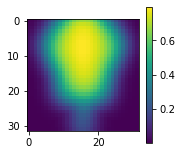

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 64
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



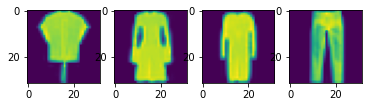

The new barycenter


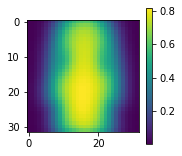

Tracking distance between new barycenter and previous barycenter :  tensor([3.9130])
Iteration number :  23
Input barycenter : 


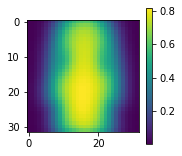

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 410
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 142
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 330
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 251
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



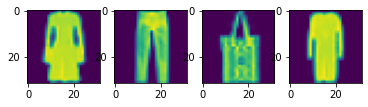

The new barycenter


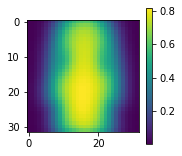

Tracking distance between new barycenter and previous barycenter :  tensor([0.9852])
Iteration number :  24
Input barycenter : 


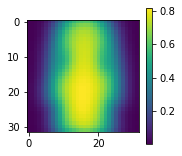

Neighbors of input barycenter :



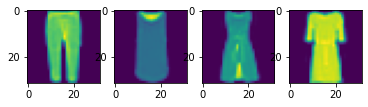

The new barycenter


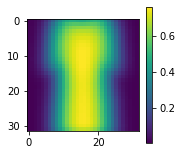

Tracking distance between new barycenter and previous barycenter :  tensor([2.3943])
Iteration number :  25
Input barycenter : 


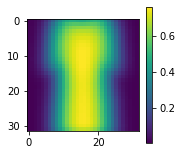

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 117
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 423
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



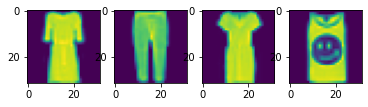

The new barycenter


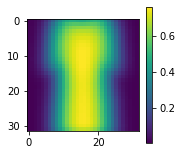

Tracking distance between new barycenter and previous barycenter :  tensor([0.9834])
Iteration number :  26
Input barycenter : 


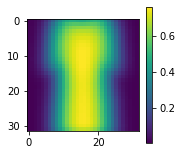

Neighbors of input barycenter :



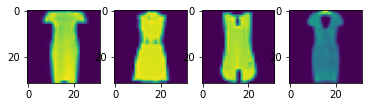

The new barycenter


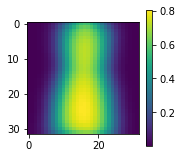

Tracking distance between new barycenter and previous barycenter :  tensor([3.7376])
Iteration number :  27
Input barycenter : 


/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 255
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


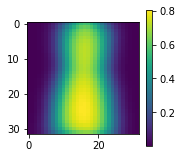

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 116
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 144
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 237
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



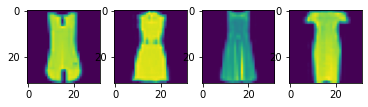

The new barycenter


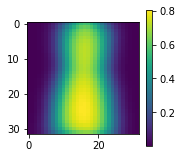

Tracking distance between new barycenter and previous barycenter :  tensor([0.9833])
Iteration number :  28
Input barycenter : 


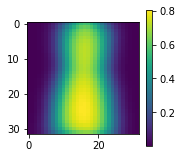

Neighbors of input barycenter :



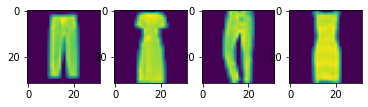

The new barycenter


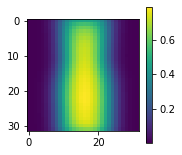

Tracking distance between new barycenter and previous barycenter :  tensor([1.5362])
Iteration number :  29
Input barycenter : 


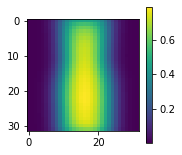

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 512
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 230
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 180
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 313
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



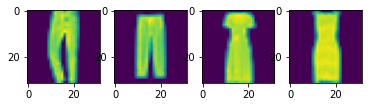

The new barycenter


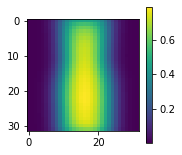

Tracking distance between new barycenter and previous barycenter :  tensor([0.9831])
Iteration number :  30
Input barycenter : 


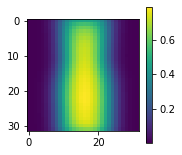

Neighbors of input barycenter :



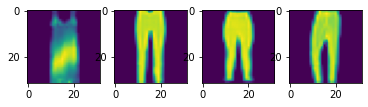

The new barycenter


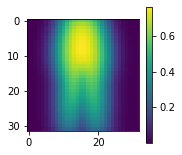

Tracking distance between new barycenter and previous barycenter :  tensor([6.3832])
Iteration number :  31
Input barycenter : 


/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 231
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


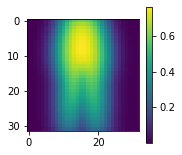

/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 112
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


Neighbors of input barycenter :



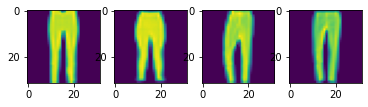

The new barycenter


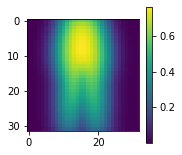

Tracking distance between new barycenter and previous barycenter :  tensor([0.9849])
Iteration number :  32
Input barycenter : 


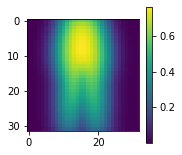

Neighbors of input barycenter :



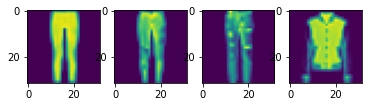

The new barycenter


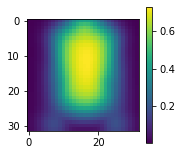

Tracking distance between new barycenter and previous barycenter :  tensor([3.1438])
Iteration number :  33
Input barycenter : 


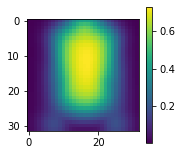

Neighbors of input barycenter :



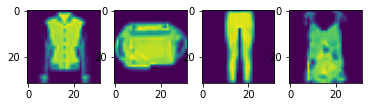

The new barycenter


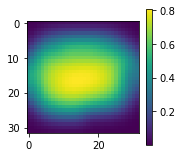

Tracking distance between new barycenter and previous barycenter :  tensor([10.0402])
Iteration number :  34
Input barycenter : 


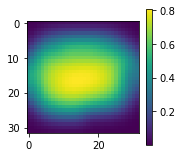

Neighbors of input barycenter :



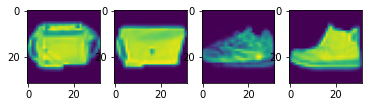

The new barycenter


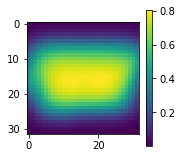

Tracking distance between new barycenter and previous barycenter :  tensor([2.0613])
Iteration number :  35
Input barycenter : 


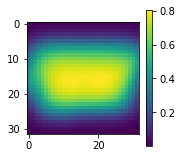

Neighbors of input barycenter :



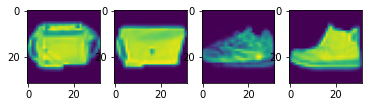

The new barycenter


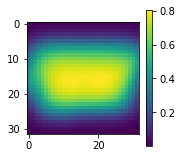

Tracking distance between new barycenter and previous barycenter :  tensor([0.9882])
Iteration number :  36
Input barycenter : 


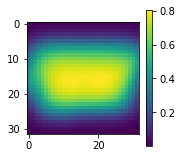

Neighbors of input barycenter :



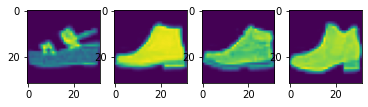

The new barycenter


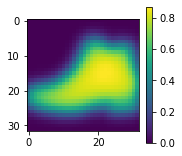

Tracking distance between new barycenter and previous barycenter :  tensor([1.1922])
Iteration number :  37
Input barycenter : 


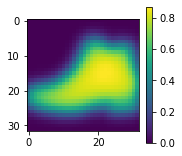

Neighbors of input barycenter :



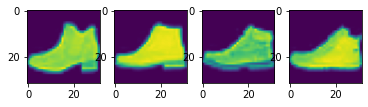

The new barycenter


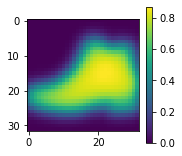

Tracking distance between new barycenter and previous barycenter :  tensor([0.9867])
Iteration number :  38
Input barycenter : 


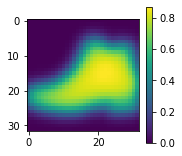

Neighbors of input barycenter :



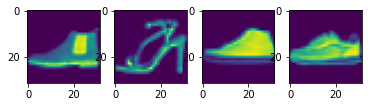

The new barycenter


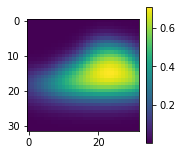

Tracking distance between new barycenter and previous barycenter :  tensor([2.8903])
Iteration number :  39
Input barycenter : 


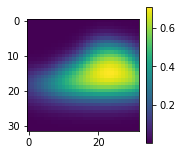

Neighbors of input barycenter :



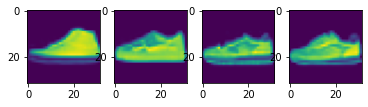

The new barycenter


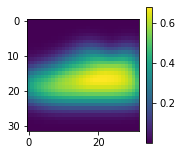

Tracking distance between new barycenter and previous barycenter :  tensor([7.4152])
Iteration number :  40
Input barycenter : 


/home/chethan/miniconda3/envs/myenv/lib/python3.9/site-packages/ot/bregman.py:492: UserWarning: Warning: numerical errors at iteration 256
  warnings.warn('Warning: numerical errors at iteration %d' % ii)


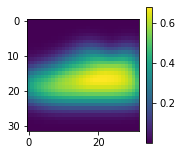

Neighbors of input barycenter :



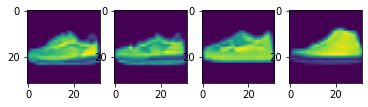

The new barycenter


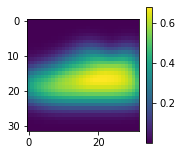

Tracking distance between new barycenter and previous barycenter :  tensor([0.9851])
Iteration number :  41
Input barycenter : 


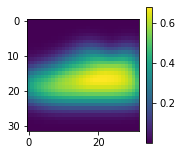

Neighbors of input barycenter :



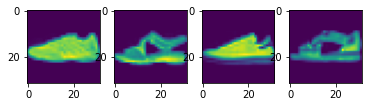

The new barycenter


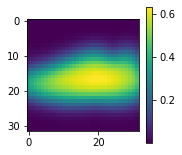

Tracking distance between new barycenter and previous barycenter :  tensor([1.1687])
Iteration number :  42
Input barycenter : 


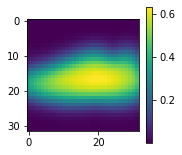

Neighbors of input barycenter :



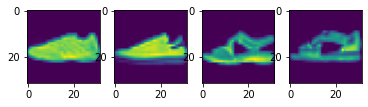

The new barycenter


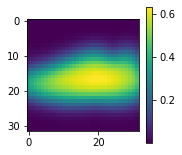

Tracking distance between new barycenter and previous barycenter :  tensor([0.9849])
Iteration number :  43
Input barycenter : 


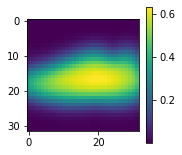

Neighbors of input barycenter :



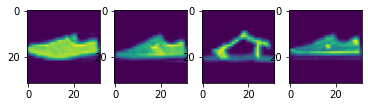

The new barycenter


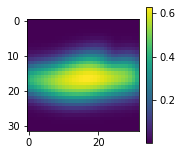

Tracking distance between new barycenter and previous barycenter :  tensor([2.3683])
Iteration number :  44
Input barycenter : 


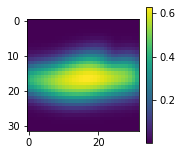

Neighbors of input barycenter :



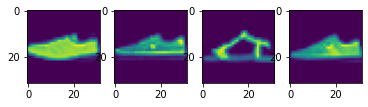

The new barycenter


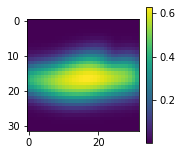

Tracking distance between new barycenter and previous barycenter :  tensor([0.9849])
Iteration number :  45
Input barycenter : 


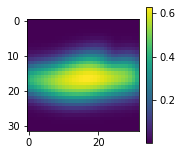

Neighbors of input barycenter :



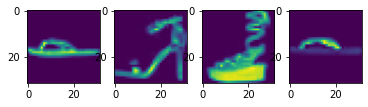

The new barycenter


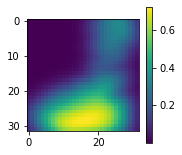

Tracking distance between new barycenter and previous barycenter :  tensor([8.9214])
Iteration number :  46
Input barycenter : 


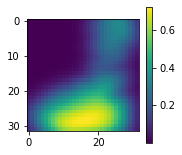

Neighbors of input barycenter :



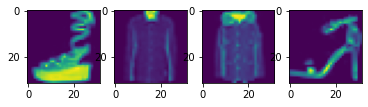

The new barycenter


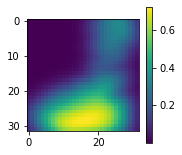

Tracking distance between new barycenter and previous barycenter :  tensor([0.9748])
Iteration number :  47
Input barycenter : 


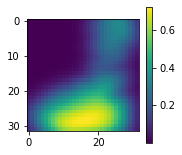

Neighbors of input barycenter :



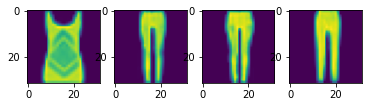

The new barycenter


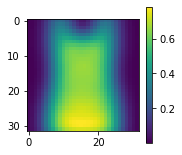

Tracking distance between new barycenter and previous barycenter :  tensor([2.3781])
Iteration number :  48
Input barycenter : 


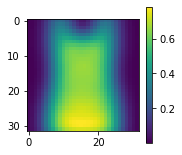

Neighbors of input barycenter :



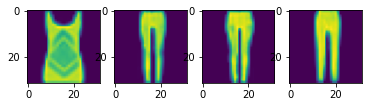

The new barycenter


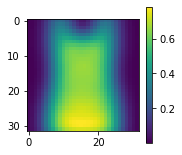

Tracking distance between new barycenter and previous barycenter :  tensor([0.9833])
END


In [20]:
bary = batch_x[0][0]
rem_indices = np.array(range(0,batch_x.shape[0]))
#Mm = [[np.sum((imageIndices[i] - imageIndices[j])**2) for i in range(len(imageIndices))] for j in range(len(imageIndices)) ]
print("Size of batch : ", batch_x.shape[0])
sampled_barycenters = np.array([])
sampled_barycenters = torch.tensor(sampled_barycenters)
covered_indices = np.array([])

for i in range(int(batch_x.shape[0])):
    
    if(len(rem_indices) < 4):
        print("END")
        break
    
    print("Iteration number : ", i+1)
    print("Input barycenter : ")
    plt.figure(figsize=(2.5, 2.5))
    plt.imshow(torch.tensor(bary).view(32,32))
    plt.colorbar()
    plt.show()
    
    old_bary = bary
    

    
    neighbours, bary, rem_indices = ImageDistancesFromBarycenter(batch_x, torch.tensor(bary), rem_indices)
    


    print("Neighbors of input barycenter :")
    print()
    f, axarr = plt.subplots(1,4)
    axarr[0].imshow(torch.tensor(neighbours[0]).view(32,32))
    axarr[1].imshow(torch.tensor(neighbours[1]).view(32,32))
    axarr[2].imshow(torch.tensor(neighbours[2]).view(32,32))
    axarr[3].imshow(torch.tensor(neighbours[3]).view(32,32))
    plt.show()

    print("The new barycenter")
    plt.figure(figsize=(2.5, 2.5))
    plt.imshow(torch.tensor(bary).view(32,32))
    plt.colorbar()
    plt.show()
    

    bary = torch.tensor(bary)

    #wassDistance = ot.sliced_wasserstein_distance(old_bary, bary, seed=0)  
    
    gs = ((torch.tensor(old_bary) + 10**(-10)).reshape(1024,1)) / torch.sum((torch.tensor(old_bary)))
    h = ((torch.tensor(bary) + 10**(-10)).reshape(1024,1)) / torch.sum((torch.tensor(bary)))
    wassDistance = ot.sinkhorn2(h, gs, Mm, 1)
    
    covered_indices = np.concatenate((covered_indices, rem_indices[:4] ) ,axis = 0)


    print("Tracking distance between new barycenter and previous barycenter : ",wassDistance )
    if(wassDistance <= 1):

        unique_covered_indices = np.unique(covered_indices, axis=0)
        sampled_barycenters = torch.cat((sampled_barycenters, torch.tensor(bary)), 0)

        s1 = set(rem_indices)
        s2 = set(unique_covered_indices)
        rem_set = s1 - s2
        rem_inds = list(rem_set)
        rem_indices = rem_set

sampled_barycenters = sampled_barycenters.reshape(int((sampled_barycenters.shape[0]*sampled_barycenters.shape[1])/1024), 32, 32)


In [21]:
wass_dist_matrix = np.zeros((sampled_barycenters.shape[0], sampled_barycenters.shape[0]))
Mmm = [[np.sum((imageIndices[i] - imageIndices[j])**2) for i in range(len(imageIndices))] for j in range(len(imageIndices)) ]

#Mmm = torch.tensor(Mmm).type(torch.FloatTensor)
#Mmm = torch.tensor(Mmm).type(torch.FloatTensor)
for i in range(sampled_barycenters.shape[0]):
    for j in range(sampled_barycenters.shape[0]):
        if(i==j):
            wass_dist_matrix[j, i] = 0
        else:
            #sampled_barycenters = sampled_barycenters.reshape(sampled_barycenters.shape[0], 1, sampled_barycenters.shape[1], sampled_barycenters.shape[2])
            gs = ((torch.tensor(sampled_barycenters[i]) + 10**(-10)).reshape(1024,1)) / torch.sum((torch.tensor(sampled_barycenters[i])))
            h = ((torch.tensor(sampled_barycenters[j]) + 10**(-10)).reshape(1024,1)) / torch.sum((torch.tensor(sampled_barycenters[j])))
            gs = gs.cpu().detach().numpy()
            h = h.cpu().detach().numpy()
            wassDistance = ot.sinkhorn2(h, gs, Mmm, 1)

            wass_dist_matrix[j, i] = wassDistance


/tmp/ipykernel_10190/3425188440.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gs = ((torch.tensor(sampled_barycenters[i]) + 10**(-10)).reshape(1024,1)) / torch.sum((torch.tensor(sampled_barycenters[i])))
/tmp/ipykernel_10190/3425188440.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  h = ((torch.tensor(sampled_barycenters[j]) + 10**(-10)).reshape(1024,1)) / torch.sum((torch.tensor(sampled_barycenters[j])))


In [22]:
wass_dist_matrix.shape

(20, 20)

In [23]:
wass_dist_matrix.shape #.cpu().detach().numpy()

(20, 20)

In [24]:
diagrams = ripser.ripser(wass_dist_matrix, distance_matrix=True, maxdim=4)['dgms']


In [25]:
diagrams

[array([[ 0.        ,  1.16874492],
        [ 0.        ,  1.19462681],
        [ 0.        ,  1.51299548],
        [ 0.        ,  1.5362649 ],
        [ 0.        ,  2.25142074],
        [ 0.        ,  2.36833358],
        [ 0.        ,  2.39415812],
        [ 0.        ,  2.42763805],
        [ 0.        ,  2.58027339],
        [ 0.        ,  2.75652099],
        [ 0.        ,  3.00187707],
        [ 0.        ,  3.16001296],
        [ 0.        ,  3.78632188],
        [ 0.        ,  4.72124672],
        [ 0.        ,  5.77497625],
        [ 0.        ,  6.61850977],
        [ 0.        ,  8.15303707],
        [ 0.        ,  8.98204422],
        [ 0.        , 30.69423103],
        [ 0.        ,         inf]]),
 array([[12.34834671, 18.73662186],
        [ 4.49667025,  4.90872622],
        [ 4.03239107,  4.3497653 ],
        [ 4.02941608,  4.39774942]]),
 array([], shape=(0, 2), dtype=float64),
 array([], shape=(0, 2), dtype=float64),
 array([], shape=(0, 2), dtype=float64)]

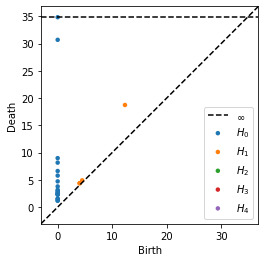

In [27]:
plot_diagrams(diagrams, show=True)

In [28]:
# Persistent homology calculation using l2 distance between barycenters

In [29]:
dist_mat_FMNIST = _compute_distance_matrix(sampled_barycenters, p=2)

/tmp/ipykernel_10190/1703124144.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  point_cloud = torch.tensor(point_cloud)


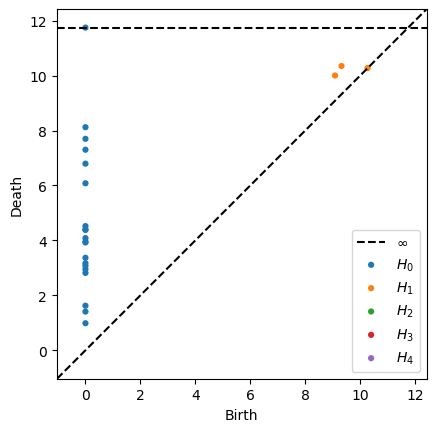

In [30]:
start = time.time()


_, PH_diagram_barycenters = get_persistence_diagram(sampled_barycenters, 4)

